# NF2FF Jitter

Implementing Python version for the jitter experiment (without comparison at first, just for one jitter value).

In [1]:
## CLONING the NF2FF Script from MATLAB: https://www.mathworks.com/matlabcentral/fileexchange/23385-nf2ff

## import statements:
import numpy as np
from matplotlib.pyplot import *
from numpy.fft import fft2
from numpy.fft import ifft2
from numpy.fft import fftshift
from numpy.fft import ifftshift
from scipy.interpolate import interp2d

from electric_field_errors import *
from NF2FF import *

import pandas
from matplotlib.colors import LogNorm

from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import RegularGridInterpolator

In [17]:
class electric_field_error:
    def __init__(self,original_field,perturbed_field,x,y,label_1,label_2):
        self.original_field = original_field
        self.perturbed_field = perturbed_field
        self.x = x
        self.y = y
        self.xlabel = label_1
        self.ylabel = label_2
    def calculate_error_metrics(self):
        ''''Returns a bunch of metrics in a Python dictionary called error_metrics that quantify the
        error between original_field and perturbed_field. Can also produce output plots if outputs argument
        is set to 1. Meant to be used in conjunction with NF2FF.
        Takes in as inputs two electric fields, and the labels for axes on plots
        x and y are values along the two axes (theta and phi for a far-field pattern)
        set outputs to 1 if want text and plot outputs. 0 (default) supresses outputs
        '''
        
        self.error=self.perturbed_field-self.original_field
        error_real=(self.error).real
        error_im=(self.error).imag
        original_field_real=(self.original_field).real
        original_field_im=(self.original_field).imag
        perturbed_field_real=(self.perturbed_field).real
        perturbed_field_im=(self.perturbed_field).imag
        self.error_amplitude=np.abs(self.error)
        self.error_phase=np.angle(self.error)
        original_field_amplitude=np.abs(self.original_field)
        perturbed_field_amplitude=np.abs(self.perturbed_field)
        original_field_phase=np.angle(self.original_field)
        perturbed_field_phase=np.angle(self.perturbed_field)

        error_real=exclude_7sigma_outliers(error_real)
        error_im=exclude_7sigma_outliers(error_im)

        # calculating weighted percent difference
        # As a vector difference of real and imaginary components
        weighted_percent_difference_real=error_real/((original_field_real+perturbed_field_real)/2)
        weighted_percent_difference_im=error_im/((original_field_im+perturbed_field_im)/2)
        self.weighted_percent_difference= weighted_percent_difference_real + 1j*weighted_percent_difference_im
        self.weighted_percent_difference_amplitude=np.abs(self.weighted_percent_difference)
        self.weighted_percent_difference_phase=np.angle(self.weighted_percent_difference)
        # Method 1 for mean: taking mean of amplitude and phase errors
        self.weighted_percent_difference_amplitude_mean=np.nanmean(self.weighted_percent_difference_amplitude)
        self.weighted_percent_difference_phase_mean=np.nanmean(self.weighted_percent_difference_phase)
        # Method 2: finding mean weighted percent difference by averaging real and imaginary components separately
        weighted_percent_difference_real_mean=np.nanmean(weighted_percent_difference_real)
        weighted_percent_difference_im_mean=np.nanmean(weighted_percent_difference_im)
        self.weighted_percent_difference_mean=weighted_percent_difference_real_mean + 1j*weighted_percent_difference_im_mean
        self.weighted_percent_difference_mean_amplitude=np.abs(self.weighted_percent_difference_mean)
        self.weighted_percent_difference_mean_phase=np.angle(self.weighted_percent_difference_mean)

        # range of the error--calculated as max - min of the error (complex subtraction between the two fields)
        error_range_real=np.nanmax(error_real)-np.nanmin(error_real)
        error_range_im=np.nanmax(error_im)-np.nanmin(error_im)
        self.error_range=error_range_real + 1j*error_range_im
        self.error_range_amplitude=np.abs(self.error_range)
        self.error_range_phase=np.angle(self.error_range)
        # doing the same for the weighted percent difference
        pct_difference_range_real=np.nanmax(weighted_percent_difference_real) - np.nanmin(weighted_percent_difference_real)
        pct_difference_range_im = np.nanmax(weighted_percent_difference_im) - np.nanmin(weighted_percent_difference_im)
        self.pct_difference_range = pct_difference_range_real + 1j*pct_difference_range_im
        self.pct_difference_range_amplitude = np.abs(self.pct_difference_range)
        self.pct_difference_range_phase = np.angle(self.pct_difference_range)

        # standard deviation of the error
        std_error_real=np.nanstd(error_real)
        std_error_im=np.nanstd(error_im)
        self.std_error = std_error_real + 1j*std_error_im
        self.std_error_amplitude = np.abs(self.std_error)
        self.std_error_phase = np.angle(self.std_error)
        # standard deviation of the percent error
        pct_diff_std_error_real = np.nanstd(weighted_percent_difference_real)
        pct_diff_std_error_im = np.nanstd(weighted_percent_difference_im)
        self.pct_diff_std_error = pct_diff_std_error_real + 1j*pct_diff_std_error_im
        self.pct_diff_std_error_amplitude = np.abs(self.pct_diff_std_error)
        self.pct_diff_std_error_phase = np.angle(self.pct_diff_std_error)

        # overall magnitude of the error: abs(original) - abs(perturbed)
        self.error_magnitudes = np.abs(self.original_field) - np.abs(self.perturbed_field)
        self.error_magnitudes_mean = np.nanmean(self.error_magnitudes)
        self.pct_error_magnitudes = np.divide(self.error_magnitudes,(np.abs(self.original_field) + np.abs(self.perturbed_field))/2)
        self.pct_error_magnitudes_mean = np.nanmean(self.pct_error_magnitudes)

        # excluding data beyond the main beam to calculate the fractional solid angle error
        dB_cutoff = -145 # this is the cutoff for the sample data provided with the MATLAB script
        power_cutoff = 10**(dB_cutoff/20)
        original_excluded_indices = original_field_amplitude < power_cutoff
        original_field_amplitude[original_excluded_indices] = float('nan')
        original_field_real[original_excluded_indices] = float('nan')
        original_field_im[original_excluded_indices] = float('nan')
        perturbed_excluded_indices = perturbed_field_amplitude < power_cutoff
        perturbed_field_amplitude[perturbed_excluded_indices] = float('nan')
        perturbed_field_real[perturbed_excluded_indices] = float('nan')
        perturbed_field_im[perturbed_excluded_indices] = float('nan')

        # calculating fractional change in solid angle for the excluded data set
        solid_angle_original = np.nansum(original_field_amplitude)
        solid_angle_perturbed = np.nansum(perturbed_field_amplitude)
        self.solid_angle_error_fraction = np.abs((solid_angle_original - solid_angle_perturbed)/solid_angle_original)
        
    def output_error_metrics(self):
        fig,ax=subplots(1,2,constrained_layout=True,figsize=(17,10))
        pcm=ax[0].pcolormesh(self.x,self.y,self.error_amplitude)
        ax[0].set_aspect('equal')
        ax[0].set_title('Difference between perturbed and original fields: amplitude')
        ax[0].set_xlabel(self.xlabel)
        ax[0].set_ylabel(self.ylabel)
        colorbar(mappable=pcm,ax=ax[0],shrink=0.7)
        pcm=ax[1].pcolormesh(self.x,self.y,self.error_phase)
        ax[1].set_aspect('equal')
        ax[1].set_title('Difference between perturbed and original fields: phase')
        ax[1].set_xlabel(self.xlabel)
        ax[1].set_ylabel(self.ylabel)
        colorbar(mappable=pcm,ax=ax[1],shrink=0.7)

        # plotting percent difference over the entire 2D grid
        fig,ax=subplots()
        pcolor(self.x,self.y,self.weighted_percent_difference_amplitude,vmax=1)
        ax.set_aspect('equal')
        ax.set_xlabel(self.xlabel)
        ax.set_ylabel(self.ylabel)
        ax.set_title('Weighted percent difference: amplitude')
        colorbar()

        # print statements
        print('Amplitude and phase of mean weighted percent difference (vector form): {}, {}'.format(self.weighted_percent_difference_mean_amplitude,self.weighted_percent_difference_mean_phase))
        print('Mean weighted percent difference in amplitude and phase: {}, {}'.format(self.weighted_percent_difference_amplitude_mean,self.weighted_percent_difference_phase_mean))
        print('Amplitude and phase of error range: {}, {}'.format(self.error_range_amplitude,self.error_range_phase))
        print('Amplitude and phase of percent difference range: {}, {}'.format(self.pct_difference_range_amplitude,self.pct_difference_range_phase))
        print('Amplitude and phase of standard deviation of the error: {}, {}'.format(self.std_error_amplitude,self.std_error_phase))
        print('Amplitude and phase of standard deviation of percent error: {}, {}'.format(self.pct_diff_std_error_amplitude,self.pct_diff_std_error_phase))
        print('Mean of amplitude(b1) - amplitude(b2): {}'.format(self.error_magnitudes_mean))
        print('Mean of pct difference amplitude metric: {}'.format(self.pct_error_magnitudes_mean))
        print('Solid angle error fraction (excluded): {}'.format(self.solid_angle_error_fraction))

In [18]:
## Specified input parameters from MATLAB folks:
broadcast_freq=94*(10**9) # broadcast frequency in hertz
sdata=np.array(pandas.read_csv('sample_data.csv',header=None)).flatten()
sdata=np.array([complex(x.replace('i','j')) for x in sdata]).reshape((51,51,201))
sdata2=np.array(pandas.read_csv('s21_data2.csv',header=None)).flatten()
sdata2=np.array([complex(x.replace('i','j')) for x in sdata2]).reshape((51,51,201))
freq=np.loadtxt('sample_frequencies.csv',delimiter=',') #Hz
N=len(freq)
f_start=freq[1]
f_stop=freq[-1]
df=(f_stop-f_start)/(N-1)
dt=1.0/(N*df)
t=np.arange(N-1)*dt

# See equations (16-10a) and (16-10b) in Balanis
M=51#sdata.xpoints; # Amount of samples in the x direction (along table, left to right)
N=51#sdata.ypoints; # Amount of samples in the y direction (across table, front to back)
dx=1/1000#sdata.x_step/1000; # Sample spacing in the x direction [m]
dy=1/1000#sdata.y_step/1000; # Sample spacing in the y direction [m]
# See equations (16-10a) and (16-10b) in Balanis
a=dx*(M-1); # The length of the scanned area in the x direction [m]
b=dy*(N-1); # The length of the scanned area in the y direction [m]
x=np.linspace(-a/2,a/2,M)
y=np.linspace(-b/2,b/2,N)
z0=0.006;

[m,n,k_X_Rectangular,k_Y_Rectangular,theta,phi] = RegularGridding(x,y,0.05,0.05)

In [19]:
# Creating jittered x, y, grid for interpolation
nyquist_sampling_m = NyquistSampling(broadcast_freq)
jitter_percentage_threshold=0.1
jitter_threshold = nyquist_sampling_m*jitter_percentage_threshold
jitter_x = -jitter_threshold + 2*jitter_threshold*np.random.rand(1,M)
jitter_y = -jitter_threshold + 2*jitter_threshold*np.random.rand(1,N)
x_jittered = x + jitter_x
y_jittered = y + jitter_y
[x_jittered_grid,y_jittered_grid] = np.meshgrid(x_jittered,y_jittered)

In [20]:
def ExtractAmplitudePhase(field):
    amplitude = np.abs(field)
    
    from skimage.restoration import unwrap_phase
    phase = unwrap_phase(np.angle(field),wrap_around=True)
    
    return amplitude, phase

In [21]:
# reading NF data into grid
find=200
f=freq[find];print(f*1e-9)
k0 = Calculate_k0(f)
NF_X_Complex=sdata[:,:,find]
NF_Y_Complex=sdata2[:,:,find]
NF_X_Magnitude = (np.abs(NF_X_Complex));
NF_Y_Magnitude = (np.abs(NF_Y_Complex));
from skimage.restoration import unwrap_phase
NF_X_Phase=unwrap_phase(np.angle(NF_X_Complex),wrap_around=True)
NF_Y_Phase=unwrap_phase(np.angle(NF_Y_Complex),wrap_around=True)

NF_X_Magnitude, NF_X_Phase = ExtractAmplitudePhase(NF_X_Complex)
NF_Y_Magnitude, NF_Y_Phase = ExtractAmplitudePhase(NF_Y_Complex)

110.0


In [22]:
# interpolating near-field data to obtain jittered near-field data
# must do real and imaginary components separately
NF_X_interp_real = RectBivariateSpline(x,y,NF_X_Complex.real)
NF_X_interp_im = RectBivariateSpline(x,y,NF_X_Complex.imag)
NF_Y_interp_real = RectBivariateSpline(x,y,NF_Y_Complex.real)
NF_Y_interp_im = RectBivariateSpline(x,y,NF_Y_Complex.imag)

# evaluating interpolation functions over jittered grid
NF_X_jittered_real = NF_X_interp_real(x_jittered,y_jittered)
NF_X_jittered_im = NF_X_interp_im(x_jittered,y_jittered)
NF_X_jittered = NF_X_jittered_real + 1j*NF_X_jittered_im
NF_Y_jittered_real = NF_Y_interp_real(x_jittered,y_jittered)
NF_Y_jittered_im = NF_Y_interp_im(x_jittered,y_jittered)
NF_Y_jittered = NF_Y_jittered_real + 1j*NF_Y_jittered_im

NF_X_jittered_Magnitude, NF_X_jittered_Phase = ExtractAmplitudePhase(NF_X_jittered)
NF_Y_jittered_Magnitude, NF_Y_jittered_Phase = ExtractAmplitudePhase(NF_Y_jittered)

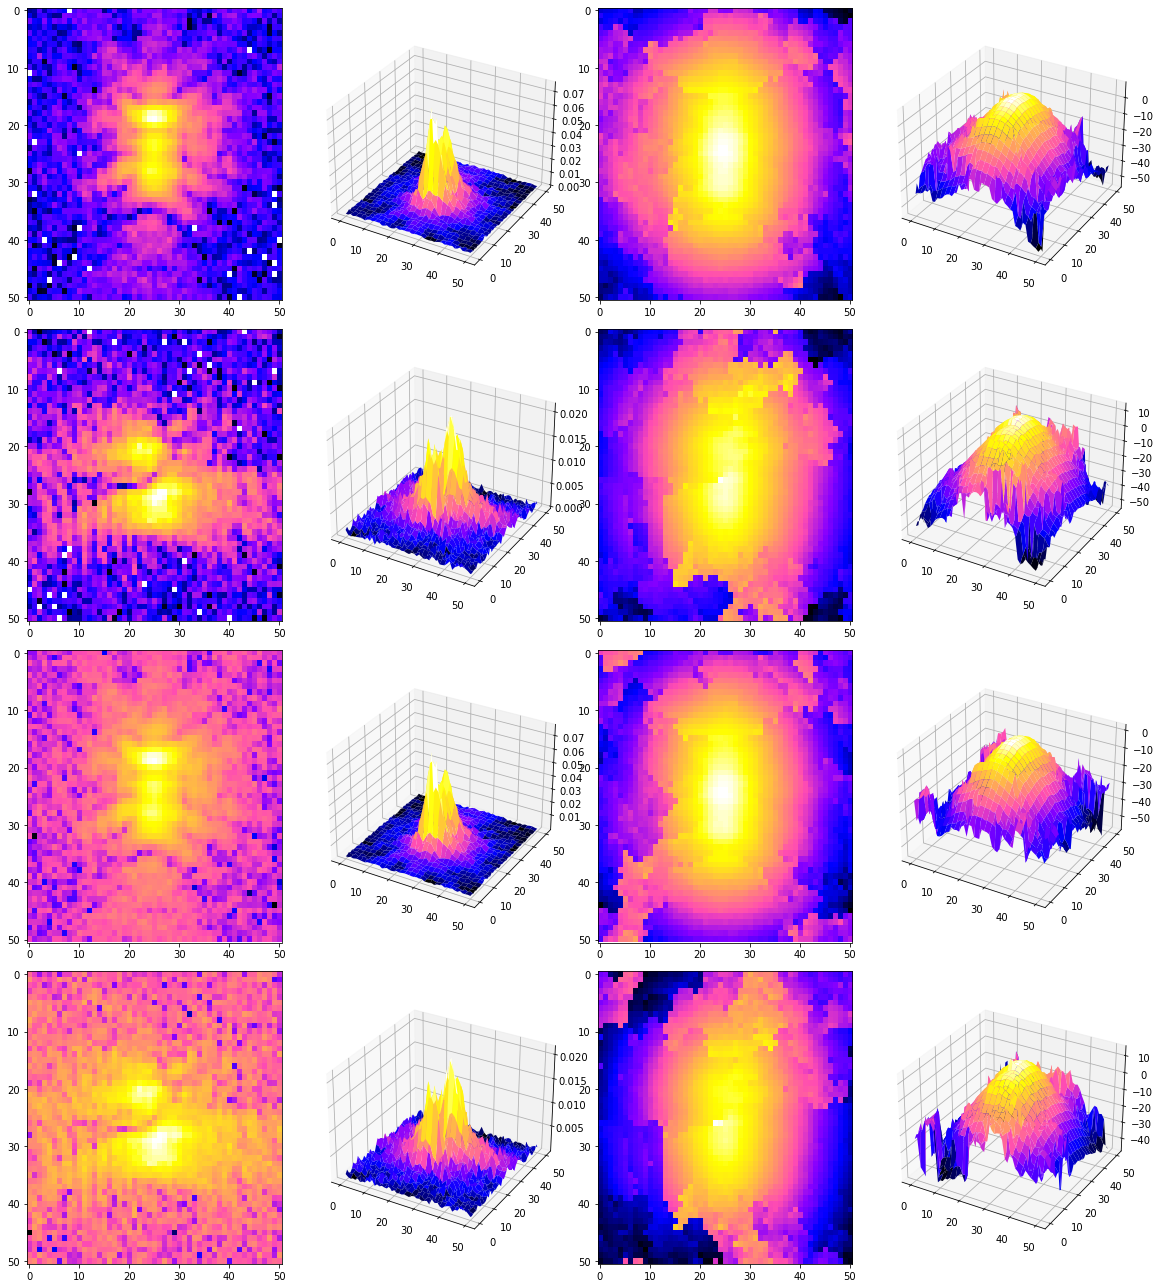

In [23]:
# plotting NF patterns

fig=figure(figsize=(16,18))
ax=fig.add_subplot(4, 4, 1)
ax.imshow(NF_X_Magnitude,aspect='auto',cmap='gnuplot2',norm=LogNorm())
ax=fig.add_subplot(4, 4, 2, projection='3d')
[X,Y]=np.meshgrid(np.arange(51),np.arange(51))
ax.plot_surface(X,Y,NF_X_Magnitude,cmap='gnuplot2',norm=LogNorm())
ax=fig.add_subplot(4, 4, 5)
ax.imshow(NF_Y_Magnitude,aspect='auto',cmap='gnuplot2',norm=LogNorm())
ax=fig.add_subplot(4, 4, 6, projection='3d')
ax.plot_surface(X,Y,NF_Y_Magnitude,cmap='gnuplot2',norm=LogNorm())
tight_layout()

ax=fig.add_subplot(4, 4, 3)
ax.imshow(NF_X_Phase,aspect='auto',cmap='gnuplot2')
ax=fig.add_subplot(4, 4, 4, projection='3d')
[X,Y]=np.meshgrid(np.arange(51),np.arange(51))
ax.plot_surface(X,Y,NF_X_Phase,cmap='gnuplot2')
ax=fig.add_subplot(4, 4, 7)
ax.imshow(NF_Y_Phase,aspect='auto',cmap='gnuplot2')
ax=fig.add_subplot(4, 4, 8, projection='3d')
ax.plot_surface(X,Y,NF_Y_Phase,cmap='gnuplot2')
tight_layout()

ax=fig.add_subplot(4, 4, 9)
ax.imshow(NF_X_jittered_Magnitude,aspect='auto',cmap='gnuplot2',norm=LogNorm())
ax=fig.add_subplot(4, 4, 10, projection='3d')
[X,Y]=np.meshgrid(np.arange(51),np.arange(51))
ax.plot_surface(X,Y,NF_X_jittered_Magnitude,cmap='gnuplot2',norm=LogNorm())
ax=fig.add_subplot(4, 4, 13)
ax.imshow(NF_Y_jittered_Magnitude,aspect='auto',cmap='gnuplot2',norm=LogNorm())
ax=fig.add_subplot(4, 4, 14, projection='3d')
ax.plot_surface(X,Y,NF_Y_jittered_Magnitude,cmap='gnuplot2',norm=LogNorm())
tight_layout()

ax=fig.add_subplot(4, 4, 11)
ax.imshow(NF_X_jittered_Phase,aspect='auto',cmap='gnuplot2')
ax=fig.add_subplot(4, 4, 12, projection='3d')
[X,Y]=np.meshgrid(np.arange(51),np.arange(51))
ax.plot_surface(X,Y,NF_X_jittered_Phase,cmap='gnuplot2')
ax=fig.add_subplot(4, 4, 15)
ax.imshow(NF_Y_jittered_Phase,aspect='auto',cmap='gnuplot2')
ax=fig.add_subplot(4, 4, 16, projection='3d')
ax.plot_surface(X,Y,NF_Y_jittered_Phase,cmap='gnuplot2')
tight_layout()

In [24]:
help(NFtoFourier)
help(FouriertoFF)

Help on function NFtoFourier in module NF2FF:

NFtoFourier(NF_X, NF_Y, kx, ky, k0, plotFourier=False)
    Function to bring NF data into k-space (plane wave spectrum). Returns a list that returns
    plane wave spectrum in x, y, z polarizations, along with their respective magnitudes.
    Input parameters:
    NF_X and NF_Y: NF data in x and y polarizations on a rectangular grid
    kx and ky: spectral frequency vector components
    k0: wave number
    plotFourier: if True, plots the plane wave spectrum over the k-space grid

Help on function FouriertoFF in module NF2FF:

FouriertoFF(f_x, f_y, f_z, theta, phi, k_x, k_y, k0, FFOutputs=False)
    Brings data from plave wave spectrum to the far-field pattern, by first inteprolating the data into
    spherical, then applying transformation.
    Returns list with [Etheta,Ephi]
    Input parameters:
    f_x, f_y, f_z: plane wave spectrum in x, y, z polarizations
    theta: vector of theta values for spherical coordinates
    phi: vector of 

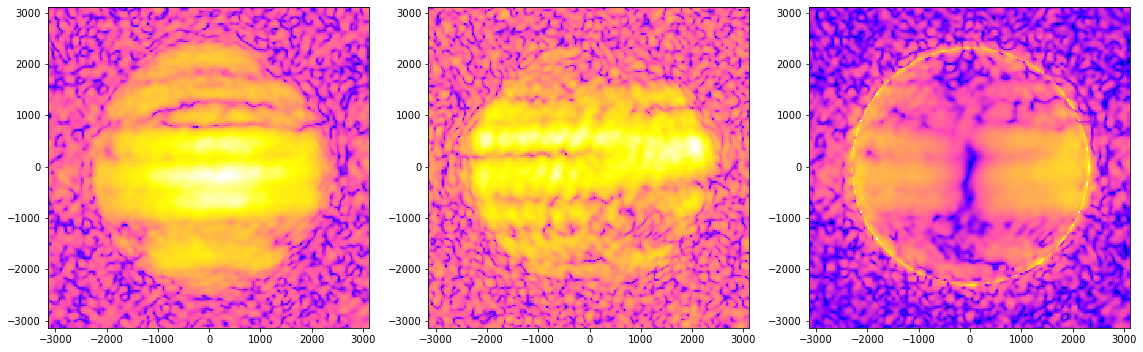

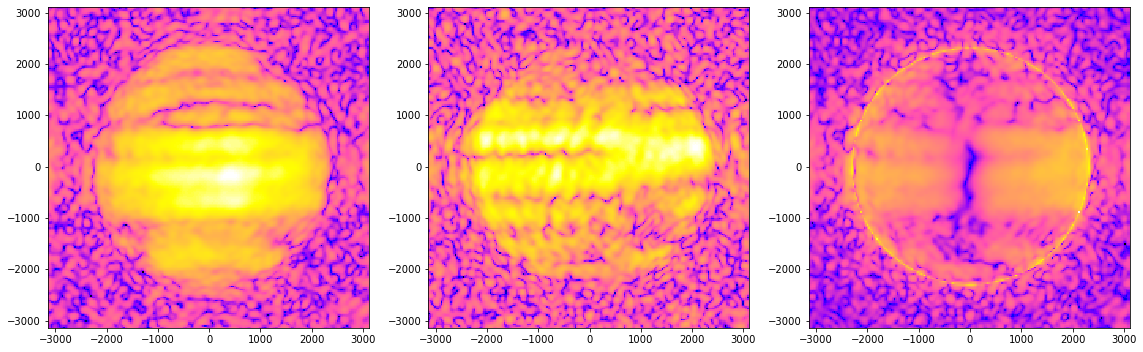

In [25]:
FourierSpace = NFtoFourier(NF_X_Complex,NF_Y_Complex,k_X_Rectangular,k_Y_Rectangular,k0,plotFourier=True)
FourierSpace_jittered = NFtoFourier(NF_X_jittered,NF_Y_jittered,k_X_Rectangular,k_Y_Rectangular,k0,plotFourier=True)

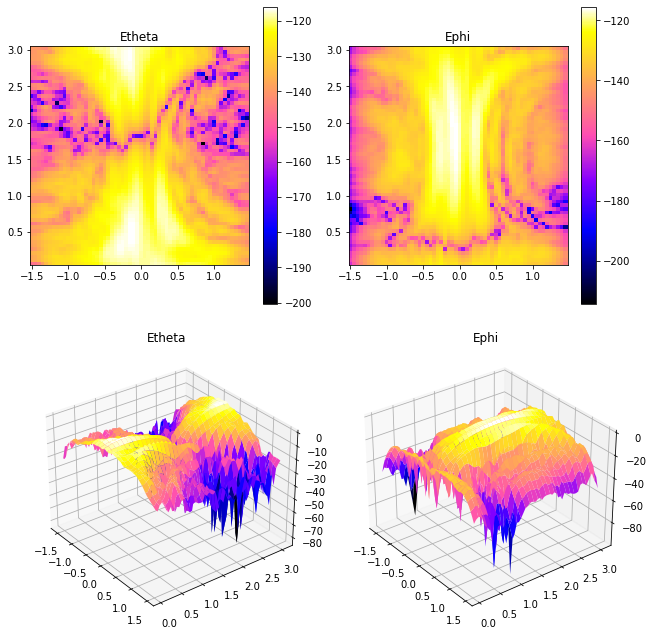

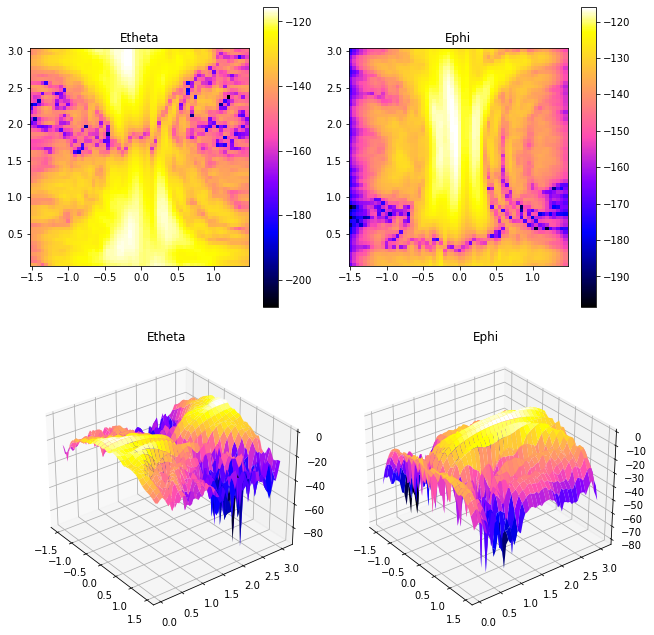

In [26]:
[Etheta,Ephi] = FouriertoFF(FourierSpace[0],FourierSpace[1],FourierSpace[2],theta,phi,k_X_Rectangular,k_Y_Rectangular,k0,FFOutputs=True)
[Etheta_jittered,Ephi_jittered] = FouriertoFF(FourierSpace_jittered[0],FourierSpace_jittered[1],FourierSpace_jittered[2],theta,phi,k_X_Rectangular,k_Y_Rectangular,k0,FFOutputs=True)

<ipython-input-17-b8b7685330b7>:103: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm=ax[0].pcolormesh(self.x,self.y,self.error_amplitude)
<ipython-input-17-b8b7685330b7>:109: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm=ax[1].pcolormesh(self.x,self.y,self.error_phase)
<ipython-input-17-b8b7685330b7>:118: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the q

Amplitude and phase of mean weighted percent difference (vector form): 0.04048268563401951, 0.7853981633974484
Mean weighted percent difference in amplitude and phase: 0.47044905808864096, -0.9563663204390856
Amplitude and phase of error range: 3.004900982120817e-07, 1.2743577010480178
Amplitude and phase of percent difference range: 265.5573865716778, 0.7853981633974482
Amplitude and phase of standard deviation of the error: 3.6394212887402686e-08, 1.2743577010480178
Amplitude and phase of standard deviation of percent error: 4.482221450036145, 0.7853981633974483
Mean of amplitude(b1) - amplitude(b2): 4.44257077042569e-09
Mean of pct difference amplitude metric: 0.024171595339780323
Solid angle error fraction (excluded): 0.011920658561682696
Amplitude and phase of mean weighted percent difference (vector form): 0.07700283857043515, 0.7853981633974481
Mean weighted percent difference in amplitude and phase: 0.37655090920289974, -1.0602136454569693
Amplitude and phase of error range: 2.

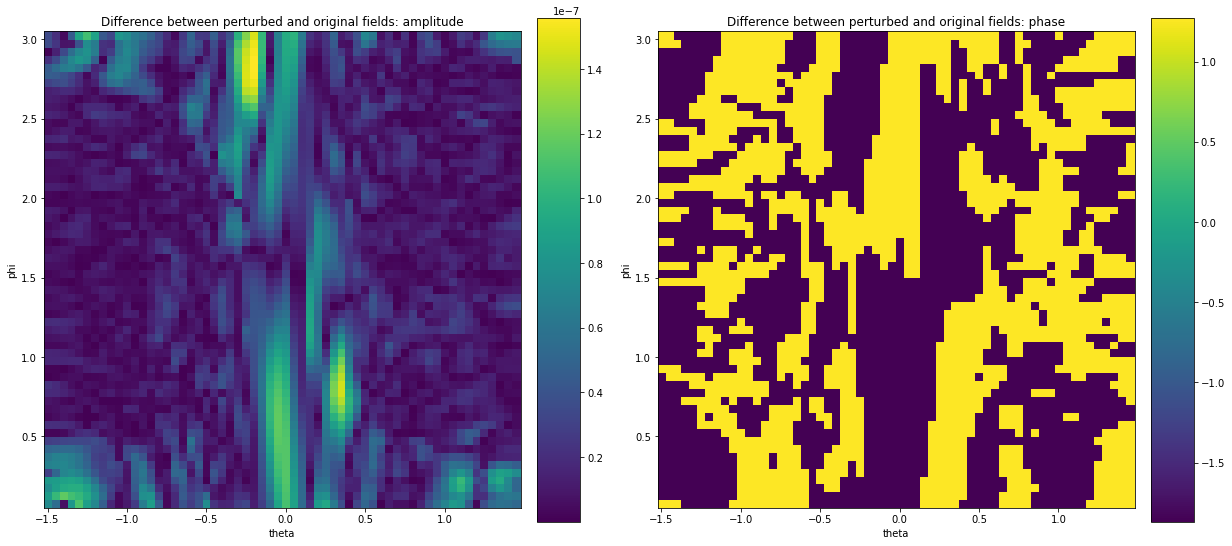

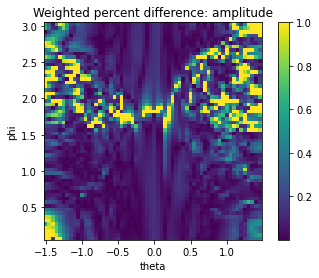

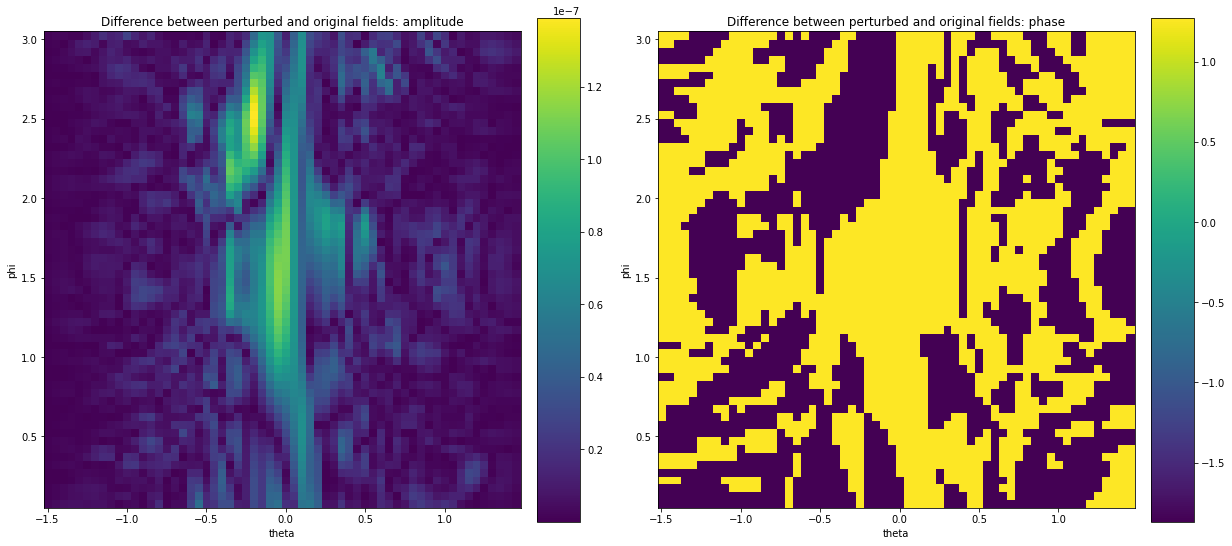

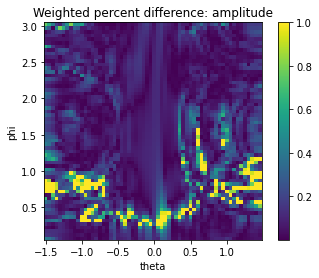

In [27]:
Etheta_errors = electric_field_error(Etheta,Etheta_jittered,theta,phi,'theta','phi')
Etheta_errors.calculate_error_metrics()
Etheta_errors.output_error_metrics()
Ephi_errors = electric_field_error(Ephi,Ephi_jittered,theta,phi,'theta','phi')
Ephi_errors.calculate_error_metrics()
Ephi_errors.output_error_metrics()

In [15]:
Etheta_errors.__dict__

{'original_field': array([[            nan           +nanj,             nan           +nanj,
          1.91775937e-08+6.27871140e-08j, ...,
          5.14379131e-08+1.68406848e-07j,  4.44226820e-08+1.45439102e-07j,
          3.91008136e-08+1.28015396e-07j],
        [ 3.79119687e-08+1.24123138e-07j,  4.30461751e-08+1.40932442e-07j,
          5.20508666e-08+1.70413648e-07j, ...,
          4.08479748e-08+1.33735571e-07j,  3.44135615e-08+1.12669412e-07j,
          3.15262241e-08+1.03216319e-07j],
        [ 3.74548622e-08+1.22626579e-07j,  4.35741253e-08+1.42660941e-07j,
          5.40482598e-08+1.76953079e-07j, ...,
          5.24729909e-08+1.71795675e-07j,  5.00268919e-08+1.63787189e-07j,
          4.85788506e-08+1.59046327e-07j],
        ...,
        [-2.82033892e-08-9.23374143e-08j, -3.10216381e-08-1.01564313e-07j,
         -3.51845959e-08-1.15193766e-07j, ...,
         -2.88106712e-08-9.43256451e-08j, -2.56706846e-08-8.40453826e-08j,
         -2.32806531e-08-7.62204603e-08j],
        [

In [23]:
E

SyntaxError: invalid syntax (<ipython-input-23-bdefdf66da3b>, line 1)